## AutoGluon Sample

In [1]:
%store -r train_file
%store -r val_file
%store -r test_file

In [2]:
train_file

'preproc_data/non_feature_engineering/train.csv'

In [3]:
import autogluon.core as ag
from autogluon.tabular import TabularPrediction as task

In [4]:
import pandas as pd
from IPython.display import display
import os

def merge_train_val(train_file, val_file, save_file_name):
    train_df = pd.read_csv(train_file)
#     display(train_df.head())
    print('train_df: ', train_df.shape)
    val_df = pd.read_csv(val_file)
#     display(val_df.head())
    print('val_df: ', val_df.shape)    
    train_val_df = pd.concat([train_df, val_df], axis=0)
#     display(train_val_df.head())    
    print('train_val_df: ', train_val_df.shape)   
    train_val_df.to_csv(save_file_name, index=None)
    print(f'{save_file_name} is saved')
    
new_train_val_folder = 'preproc_data/non_feature_engineering/train_val'
os.makedirs(new_train_val_folder, exist_ok=True)
train_val_file_path = os.path.join(new_train_val_folder, 'train_val.csv')
    
merge_train_val(train_file, val_file, train_val_file_path)    

train_df:  (47023, 17)
val_df:  (13435, 17)
train_val_df:  (60458, 17)
preproc_data/non_feature_engineering/train_val/train_val.csv is saved


In [5]:
train_data = task.Dataset(file_path=train_val_file_path)
subsample_size = train_data.shape[0]
# subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head())

       classes  customer_zip_code_prefix   customer_city customer_state  \
49649        4                     85760        capanema             PR   
14975        4                     36240   santos dumont             MG   
7275         2                     12312         jacarei             SP   
28089        4                     20725  rio de janeiro             RJ   
22946        4                     21221  rio de janeiro             RJ   

        price  freight_value  product_weight_g  product_length_cm  \
49649   24.99          18.28             237.0               19.0   
14975  129.90          23.84            2600.0               65.0   
7275    27.90           8.36             800.0               26.0   
28089   65.00          16.89            1032.0               17.0   
22946   49.90          17.09            1400.0               43.0   

       product_height_cm  product_width_cm product_category_name_english  \
49649                7.0              15.0                

In [6]:
label_column = 'classes'
print("Summary of class variable: \n", train_data[label_column].describe())

Summary of class variable: 
 count    60458.000000
mean         2.090890
std          1.152709
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: classes, dtype: float64


In [ ]:
%%time
dir = 'agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
presets = 'best_quality'
# presets = 'medium_quality_faster_train'

predictor = task.fit(train_data=train_data, label=label_column, 
                     output_directory=dir,
                     time_limits=time_limits,
                     presets=presets)



Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to agModels-predictClass/
AutoGluon Version:  0.0.15b20201025
Train Data Rows:    60458
Train Data Columns: 16
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [4, 2, 1, 0, 3]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
	Available Memory:                    62877.36 MB
	Train Data (Original)  Memory Usage: 36.4 MB (0.1% of available memory)
	Inferring data type of each feature based on c

In [16]:
test_data = task.Dataset(file_path=test_file)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head())

Loaded data from: preproc_data/non_feature_engineering/test.csv | Columns = 17 / 17 | Rows = 6718 -> 6718


   customer_zip_code_prefix        customer_city customer_state   price  \
0                     12951              atibaia             SP   35.00   
1                     64016             teresina             PI   21.99   
2                     37900               passos             MG   69.90   
3                     71510             brasilia             DF  284.90   
4                     12244  sao jose dos campos             SP  129.90   

   freight_value  product_weight_g  product_length_cm  product_height_cm  \
0           8.41             350.0               21.0                9.0   
1          22.85             300.0               17.0                4.0   
2          18.59             125.0               20.0               16.0   
3          18.29             610.0               18.0               12.0   
4          12.30            1700.0               30.0               35.0   

   product_width_cm product_category_name_english  seller_zip_code_prefix  \
0              

In [17]:
predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.38687109258707947
Evaluations on test data:
{
    "accuracy": 0.38687109258707947,
    "accuracy_score": 0.38687109258707947,
    "balanced_accuracy_score": 0.31859902812046376,
    "matthews_corrcoef": 0.1705397849418739
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.43555555555555553,
        "recall": 0.15530903328050713,
        "f1-score": 0.22897196261682243,
        "support": 631
    },
    "1": {
        "precision": 0.4118380062305296,
        "recall": 0.43287491814014406,
        "f1-score": 0.42209450830140477,
        "support": 1527
    },
    "2": {
        "precision": 0.3889071217591073,
        "recall": 0.5514192647743137,
        "f1-score": 0.45612009237875284,
        "support": 2149
    },
    "3": {
        "precision": 0.35613927916921195,
        "recall": 0.3648310387984981,
        "f1-score": 0.3604327666151468,
        "support": 1598
    },
    "4": {
        "precision": 0.352941176

Predictions:   [1 3 3 ... 1 3 1]


In [18]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestClassifierGini_STACKER_l1,0.403989,0.407192,467.515146,59.015825,1860.545983,40.120861,1.170725,50.884197,1,True,16
1,LightGBMClassifierXT_STACKER_l1,0.401905,0.405968,427.861781,58.199518,1821.780114,0.467495,0.354419,12.118328,1,True,21
2,weighted_ensemble_k0_l1,0.400863,0.402511,110.778979,51.827913,1717.370458,0.024183,0.006774,8.167457,1,True,12
3,CatboostClassifier_STACKER_l1,0.400714,0.407638,428.066673,58.562325,1869.510473,0.672388,0.717225,59.848687,1,True,22
4,RandomForestClassifierEntr_STACKER_l1,0.400268,0.405918,470.433283,59.016896,1957.269047,43.038997,1.171796,147.607261,1,True,17
5,ExtraTreesClassifierEntr_STACKER_l1,0.399821,0.409855,521.439329,59.007678,1836.782141,94.045044,1.162578,27.120355,1,True,19
6,ExtraTreesClassifierGini_STACKER_l1,0.398779,0.408829,515.477870,59.011235,1831.744345,88.083584,1.166135,22.082559,1,True,18
7,NeuralNetClassifier_STACKER_l1,0.396547,0.400030,476.424966,108.076490,3271.838962,49.030680,50.231390,1462.177176,1,True,13
8,CatboostClassifier_STACKER_l0,0.395653,0.400245,0.949041,0.699379,66.480952,0.949041,0.699379,66.480952,0,True,10
9,RandomForestClassifierEntr_STACKER_l0,0.395653,0.372076,63.282787,1.145620,50.366971,63.282787,1.145620,50.366971,0,True,5


In [19]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.39%
f1_score: 0.32%


[[  98  440   80   13    0]
 [  93  661  635  126   12]
 [  26  331 1185  565   42]
 [   6  124  807  583   78]
 [   2   49  340  350   72]]


<Figure size 432x288 with 0 Axes>

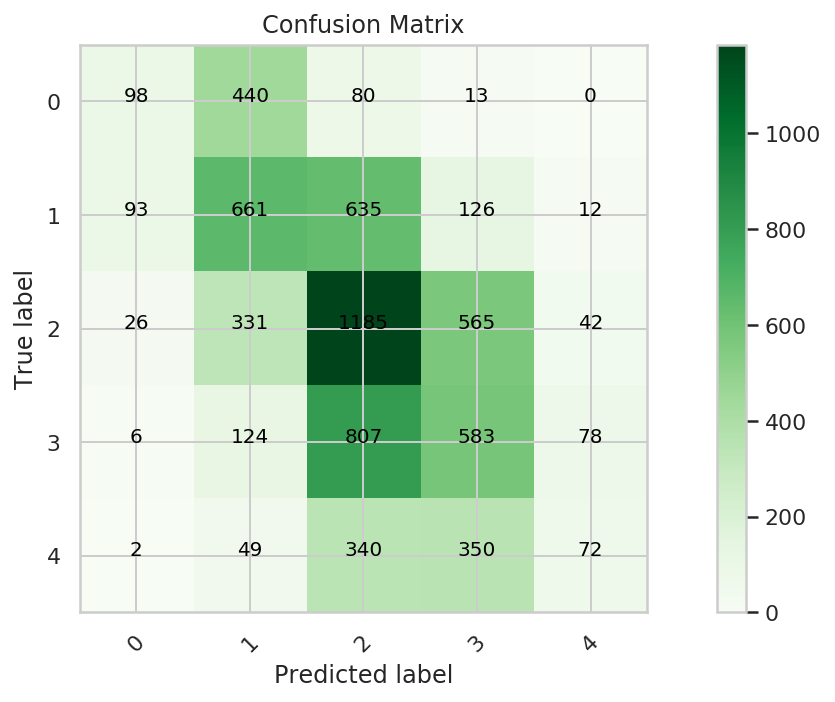

In [20]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

Computing raw permutation importance for 16 features on weighted_ensemble_k0_l2 ...
	9825.43s	= Expected runtime
